<a href="https://colab.research.google.com/github/guiattard/PythonForGeosciences/blob/master/geostatistics-applied-to-hydrogeology-with-scikit-gstat/geostatistics-applied-to-hydrogeology-with-scikit-gstat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2020 Guillaume Attard { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Geostatistics applied to hydrogeology with Scikit-GStat

by [Guilllaume Attard](https://guillaumeattard.com/) - pythonforgeosciences.com

last update 18-12-2020

Notebook status : *Under construction*

## Introduction

### Context

Spatially continuous data play a significant role in planning, risk assessment and decision making in environmental management [(Li et al. 2011)](https://doi.org/10.1016/j.envsoft.2011.07.004). However, these data are not always available and often difficult or expensive to acquire. The acquisition of environmental data such as groundwater temperature, hydraulic head, substance concentration of soil are usually collected by point sampling. Then, geoscientists often require spatial interpolation methods to get spatially continuous data over a region of interest: here comes the Geostatistics. 

### What is geostatistics?

Geostatistics is a branch of statistics focusing on spatial or spatiotemporal datasets. Developed originally to predict probability distributions of ore grades for mining operations, it is currently applied in diverse disciplines including petroleum geology, hydrogeology, hydrology, meteorology, oceanography, geochemistry, geometallurgy, geography, forestry, environmental control, landscape ecology, soil science, and agriculture ([wikipedia definition](https://en.wikipedia.org/wiki/Geostatistics)).

The principle of geostatistic is well resumed on the [documentation webpage](https://mmaelicke.github.io/scikit-gstat/SciKitGStat.pdf): 
>The basic idea of geostatistics is to describe and estimate spatial correlations in a set of point data. The typical application is geostatistics is an interpolation. Therefore, although using point data, a basic concept is to understand these point data as a sample of a (spatially) continuous variable that can be described as a random field, or to be more precise, a Gaussian random field in many cases. The most fundamental assumption in geostatistics is that any two values xi and xi+h are more similar, the smaller h is, which is a separating distance on the random field. In other words: close observation points will show higher covariances than distant points. In case this most fundamental conceptual assumption does not hold for a specific variable, geostatistics will not be the correct tool to analyse and interpolate this variable.

### What we do here

The aim of this notebook is to build a piezometric map using the Python Scikit-GStat library and to compare the results with other standard interpolation techniques. After some setups, we will download a dataset of points giving hydraulic head of a groundwater body located in the area of Lyon (France) and we will clean this dataset to eliminate all points outside of our groundwater body of interest.

In a second part, we will apply two standard interpolation methods (i.e. linear and cubic) given by the *griddata* function (from *scipy.interpolate*) to map the hydraulic head across our area of interest. The limits of both interpolations methods will be discused.

Finally, we will explore the ordinary kriging method given by the Scikit-GStat library:
- We will first build a semi-variogramm exploring different parameters to better understand the relationship between measurements variablity and distance between measurements. 
- Secondly, we will build an ordinary kriging model to interpolate the hydraulic head across our area of interest. 
- We will finally see how to plot the error estimation across our area of interest.

Please note the reference of this library:and the full documentation:
-  *Mirko Mälicke, & Helge David Schneider. (2020, October 4). Scikit-GStat 0.3.0: A scipy flavoured geostatistical analysis toolbox written in Python. (Version v0.3.0). Zenodo. http://doi.org/10.5281/zenodo.4065199*,
- the full documentation of this Python library can be downloaded [here](https://mmaelicke.github.io/scikit-gstat/SciKitGStat.pdf).

Finally, please note that the name kriging refers to its inventor Dave Krige who published the method in 1951: 
- *Krige, D. G. (1951). A statistical approach to some basic mine valuation problems on the Witwatersrand. Journal of the Southern African Institute of Mining and Metallurgy, 52(6), 119-139.*

## Run me first

Two options are proposed to install scikit-gstat. Please select the one you prefer.

### Option 1: Install  scikit-gstat with PyPi

To run option 1, uncomment and run the cell below:

In [ ]:
!pip install scikit-gstat

### Option2: Install the most recent version from GitHub

To run option 2, please copy/past following instructions into your powershell/terminal:
```
git clone https://github.com/mmaelicke/scikit-gstat.git
cd scikit-gstat
pip install -r requirements.txt
python setup.py install
```

### Install/Import other libraries

We first need to install and import some libraries:

In [ ]:
!apt install gdal-bin python-gdal python3-gdal
!pip install fiona shapely pyproj
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install git+https://github.com/python-visualization/folium
!pip install plotly

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# We import the folium library to make interactive maps
import folium

# We need to import branca.colormap to give pretty colors to our points according 
# to groundwater table elevation
import branca.colormap as cm

# We need requests to get our dataset and zipfile to unzip our dataset
import requests
import zipfile

%matplotlib inline

### Import our hydraulic head dataset

The hydraulic head dataset we are working with is available on the github repository of this notebook. Please note that this dataset is derived from a dataset provided by the french geological survey. Please visit a [previous notebook](https://github.com/guiattard/PythonForGeosciences/tree/master/exploring-hydro-geological-data-of-france-with-python) to see how to explore french hydrogeological data.

In [3]:
url = "https://github.com/guiattard/PythonForGeosciences/raw/master/geostatistics-applied-to-hydrogeology-with-scikit-gstat/hydraulic-head-lyon-sample.zip"
file = "hydraulic-head-lyon-sample.zip"
# Command to donwload the file at the given url
r = requests.get(url)

# Then we open the file
open(file, 'wb').write(r.content)

# We extract the content of the .zip file
with zipfile.ZipFile(file, 'r') as unzip: unzip.extractall("./dat")

# we finally read the shapefile and make some cleaning
gdf = gpd.read_file("./dat/hydraulic-head-sample-lyon.shp")

# We rename the hydraulic name column by hh
gdf = gdf.rename(columns = {'hydraulic_' : "hh"})
gdf.head()

,lon,lat,x,y,z,depth,hh,geometry
0,4.765518,45.698014,837377.0,6512474.0,229.0,30.0,203.0,POINT (837377.000 6512474.000)
1,4.931568,45.808866,849994.0,6525083.0,175.0,10.0,169.4,POINT (849994.000 6525083.000)
2,4.929721,45.812410,849841.0,6525473.0,182.0,21.5,167.5,POINT (849841.000 6525473.000)
3,4.832399,45.827318,842247.0,6526948.0,285.0,14.5,282.0,POINT (842247.000 6526948.000)
4,4.748208,45.812863,835748.0,6525195.0,330.0,11.7,323.7,POINT (835748.000 6525195.000)


We can display the location of our points on a static map using <code>matplotlib</code>:

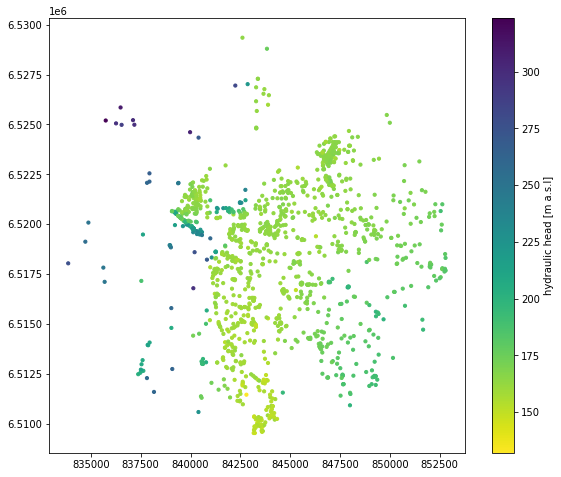

In [5]:
# We plot the result
fig, ax = plt.subplots(figsize=(10,8))

# We add the location of borehole with hydraulic head
gdf.plot(ax = ax, cmap = "viridis_r",
            column = "hh",
            markersize=10, 
            legend = True,
            legend_kwds={'label': "hydraulic head [m a.s.l]"})

plt.show()

Now, let's display the location of our points on an interactive map using <code>folium</code>. We also add geological tile layers of France using the <code>folium.WmsTileLayer</code> method (please note that we work with longitudes and latitudes with <code>folium</code>):

In [4]:
# We build our map focusing on our site and specifying the zoom start
mymap = folium.Map(location=[gdf.lat.mean(), gdf.lon.mean()], 
                   zoom_start=12,
                   show=True, control_scale = True)

# Add the geological map of France
url = 'http://geoservices.brgm.fr/geologie'
layer1 = 'GEOLOGIE'
folium.WmsTileLayer(url, layer1, attr = 'BRGM', name = 'Geological map', show=True).add_to(mymap)

# Add a feature group to add borehole with hydraulic head measurements
fg_gwt = folium.FeatureGroup(name = 'Hydraulic head', show = True)
mymap.add_child(fg_gwt)

colormap = cm.LinearColormap(colors=['orange', 'yellow', 'green', 'lightblue', 'blue'], 
                             index=[gdf["hh"].quantile(0.1),
                                    gdf["hh"].quantile(0.25),
                                    gdf["hh"].quantile(0.5),
                                    gdf["hh"].quantile(0.75),
                                    gdf["hh"].quantile(0.9)], 
                             vmin=gdf["hh"].quantile(0.1),
                             vmax=gdf["hh"].quantile(0.9))

# We add the caption of our colormap
colormap.caption = 'Hydraulic head [m asl]'

# We add all points of our dataset
for i, h in zip(gdf.index.values, gdf.hh.values):
    dfi = folium.CircleMarker(
        location = [gdf.at[i,'lat'], gdf.at[i,'lon']],
        popup =str(round(h,2)) + " m asl",
        radius= 7,
        fill=True,
        fill_opacity=0.7,
        color = colormap(h),
        fill_color = colormap(h))
    dfi.add_to(fg_gwt)

mymap.add_child(colormap)
mymap.add_child(folium.map.LayerControl(collapsed=True))

Another good possibility to map the locations is the `plotly` plotting library. One advantage is, that recent versions of `scikit-gstat` can make use of that library to return interactive plots. You can easily switch between plotly and matplotlib as a plotting backend.

In [23]:
import plotly.express as px

# create the scatter_mapbox
fig = px.scatter_mapbox(gdf, 
    lat='lat', lon='lon', zoom=12, height=450,  
    hover_data=['hh', 'depth'], color='hh', size='hh'
)

# use a base-style that does not need a MAPBOX token
fig.update_layout(
    mapbox_style='stamen-terrain',
    mapbox=dict(pitch=60),
)

# get rid of margins
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

### Cleaning our dataset

Before any interpolation, we need to clean our dataset. Particularly, we need to exclude all points which are not located in our groundwater body of interest. In this area there are several groundwater bodies and we make the choice to work on the shallow alluvial groundwater body. It includes groundwater flowing through fuvio-glacial corridors (on the eastern part of our available dataset), and groundwater flowing through the modern alluvial deposit.

To do so, we need to make a spatial join between our dataset and the shape of our groundwater body. The shape of the relevant groundwater body can be downloaded as follow (please note that provided file is an incomplete shape of the real groundwater body):

In [24]:
url = "https://github.com/guiattard/PythonForGeosciences/raw/master/geostatistics-applied-to-hydrogeology-with-scikit-gstat/gw-body.zip"
file = "gw-body.zip"
# Command to donwload the file at the given url
r = requests.get(url)

# Then we open the file
open(file, 'wb').write(r.content)

# We extract the content of the .zip file
with zipfile.ZipFile(file, 'r') as unzip: unzip.extractall("./dat")

# we finally read the shapefile
area = gpd.read_file("./dat/gw-body.shp")

area.head()

,Id,geometry
0,0,"POLYGON ((842759.853 6520597.298, 842752.227 6..."


We then make the spatial join and display the location of both files:

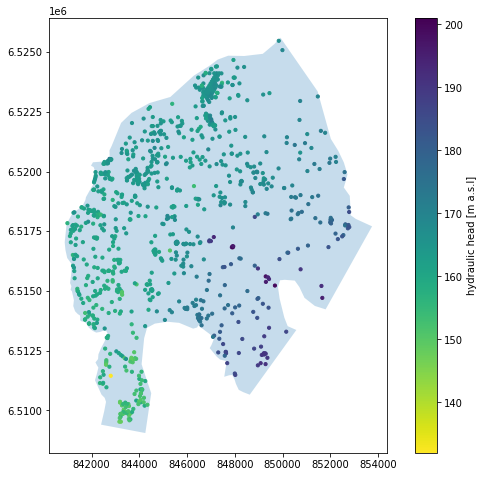

In [25]:
# Spatial join
gdf = gpd.sjoin(gdf, area, op = "within")

# PLot the results
fig, ax = plt.subplots(figsize=(10,8))

area.plot(ax = ax, alpha = 0.25)

# We add the location of borehole with water level in blue
gdf.plot(ax = ax, cmap = "viridis_r",
            column = "hh",
            markersize=10, 
            legend = True,
            legend_kwds={'label': "hydraulic head [m a.s.l]"})
plt.show()

We can also display some histograms using the `hist` method and boxplots using the `boxplot` method to have a closer look on how our values (i.e. hydraulic head `hh` and ground elevation `z`) are distributed:

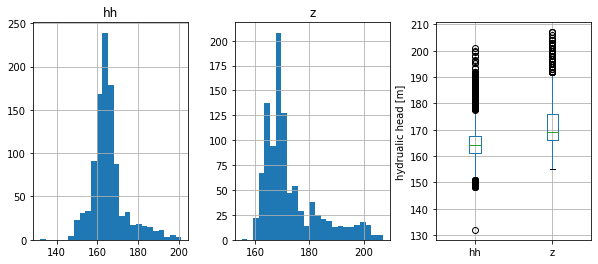

In [31]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
ax = axs[0:2]
gdf[['hh', 'z']].hist(ax = ax, bins=25)

ax = axs[2]
ax.set_ylabel('hydrualic head [m]')
gdf[['hh', 'z']].boxplot(ax = ax)

plt.show()

The hydraulic head boxplot put in evidence a very low outlier (around 130 m). This point can easily be identified in yellow on the previous map, in the south of our area of interest. Considering the very low hydraulic gradient of the groundwater body we are studying (about 0.2\%) and other measurements around, this value is clearly an error and should be removed from our analysis (or maybe not an error but a hydraulic head measurement inside a pumping well). Then, let's remove points where hydraulic head is lower than 145 m and display our cleaned dataset (please note that we could have gone further to clean this dataset):

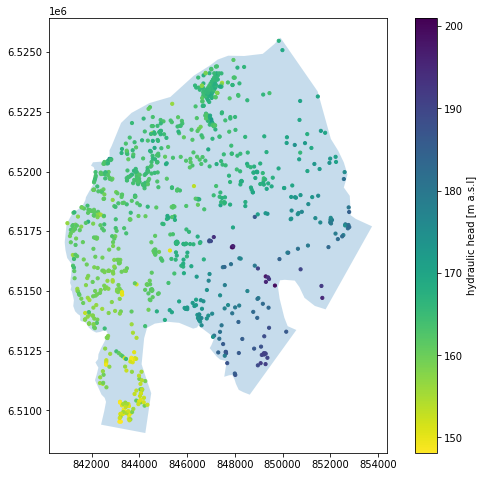

In [32]:
gdf = gdf[gdf.hh > 145]

# PLot the results
fig, ax = plt.subplots(figsize=(10,8))

area.plot(ax = ax, alpha = 0.25)

# We add the location of borehole with water level in blue
gdf.plot(ax = ax, cmap = "viridis_r",
            column = "hh",
            markersize=10, 
            legend = True,
            legend_kwds={'label': "hydraulic head [m a.s.l]"})
plt.show()

## Application of two standard interpolation techniques using `griddata`

### Creation of a grid over the area of interest

First, we need to build a meshgrid over the area of interest. A mesh-grid is a grid of coordinates, in which each value simply holds the indices of the position in the grid. In our case, the meshgrid is two dimensional, therefore the two grid-arrays (for x and y) will hold all coordinates present in the grid. We need to create this grid, as the coordinates are the input data for the `griddata` function. To do so, we need to specify the resolution of the grid we want (the number of values between our x-min and our x-max and similarly in the y-direction) and build the grid using the `numpy.mgrid` method: 

In [37]:
# We determine xmin, xmax, ymin and ymax from our dataset:
xv = gdf['x'].values
yv = gdf['y'].values

xmin, xmax = min(xv), max(xv)
ymin, ymax = min(yv), max(yv)

# We determine the resolution in x direction:
res_x = 100
# We determine the resolution in y direction
# based on res_x to make a regular grid:
res_y = int((ymax - ymin)*res_x/(xmax - xmin))

# We build the grid:
xx,yy = np.mgrid[xmin:xmax:complex(res_x), 
                 ymin:ymax:complex(res_y)]

print('X coordinates:\n', xx[:5,:5].round(1))
print('Y coordinates:\n', yy[:5,:5].round(1))

X coordinates:
 [[840990.  840990.  840990.  840990.  840990. ]
 [841109.2 841109.2 841109.2 841109.2 841109.2]
 [841228.4 841228.4 841228.4 841228.4 841228.4]
 [841347.7 841347.7 841347.7 841347.7 841347.7]
 [841466.9 841466.9 841466.9 841466.9 841466.9]]
Y coordinates:
 [[6509524.  6509643.  6509762.  6509881.1 6510000.1]
 [6509524.  6509643.  6509762.  6509881.1 6510000.1]
 [6509524.  6509643.  6509762.  6509881.1 6510000.1]
 [6509524.  6509643.  6509762.  6509881.1 6510000.1]
 [6509524.  6509643.  6509762.  6509881.1 6510000.1]]


### Linear and cubic interpolations

Then, we can easily make boths interpolations (linear and cubic) of hydraulic head value on our regular grid by using the `griddata` function from the `scipy` library:

In [38]:
from scipy.interpolate import griddata

# We put the x/y coordinates of our dataset into an array
points = np.asanyarray(gdf[['x', 'y']])

# We put our hydraulic head values of our dataset into list of the same dimension
values = gdf['hh'].values

# We make the linear interpolation
HH_LINEAR = griddata(points, values, (xx, yy), method='linear')

# We make the cubic interpolation
HH_CUBIC = griddata(points, values, (xx, yy), method='cubic')

We can now plot the results given by both techniques:

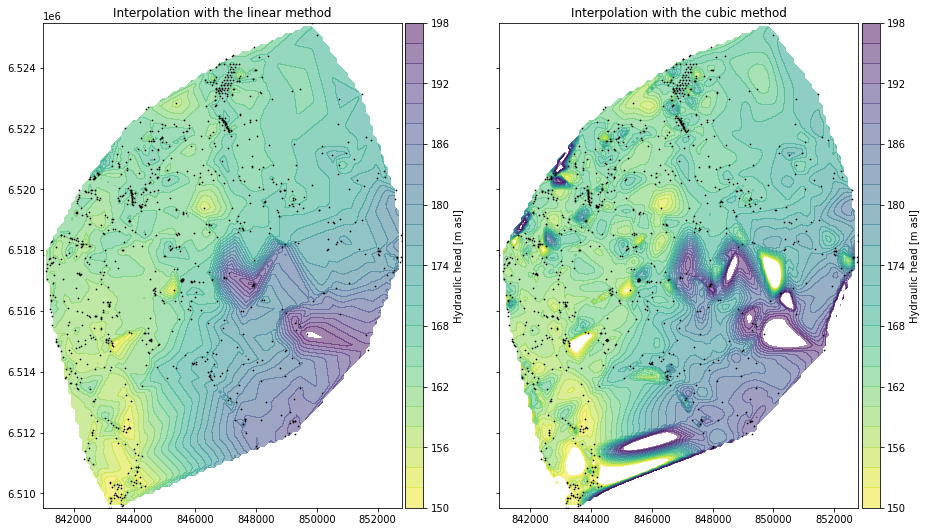

In [39]:
fig, axs = plt.subplots(1,2, figsize=(15, 10), sharey=True)

ax =axs[0]
# We plot contour fringes based on our linear griddata interpolation
ctr_linear = ax.contourf(xx, 
                         yy, 
                         HH_LINEAR,
                         range(150,200,2),
                         cmap = "viridis_r", 
                         alpha = 0.5)

# Some parameters to make a pretty fig:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_linear, cax=cax, label = 'Hydraulic head [m asl]')
ax.set_title("Interpolation with the linear method")

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

ax =axs[1]
# We plot contour fringes based on our cubic griddata interpolation
ctr_cubic = ax.contourf(xx, 
                        yy, 
                        HH_CUBIC,
                        range(150,200,2),
                        cmap = "viridis_r",
                        alpha = 0.5)

# Some parameters to make a pretty fig:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_cubic, cax=cax, label = 'Hydraulic head [m asl]')

ax.set_title("Interpolation with the cubic method")

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

plt.show()

### Limits of standard interpolations techniques

The previous figure shows that linear and cubic interpolations techniques give very different results. It is explained by the fact that the weight given by neighboring points to estimate a value is of course not the same. According to the `scipy.interpolate.griddata` [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html):
- the `linear` method tessellates the input point set to N-D simplices, and interpolate linearly on each simplex.
- the `cubic` method returns the value determined from a [cubic spline](https://en.wikipedia.org/wiki/Spline_(mathematics).

Of course, both techniques can gives pretty good results for dense and regularly spaced datasets, but these conditions barely happened when handling environmental measurements/sampling which are often scattered and non-uniformly distributed. Under such conditions, these techniques have several drawbacks:
- the weighted model is completely arbitrary and doest not account for spatial variability of measurements,
- we have no idea of the variance/error associated to the interpolation method,
- the cubic method trend to emphasis on diverging values (we can easily check that with the multiple circular zones on the figure)
- it is not possible to make extrapolations with these methods.
- both methods use splines and can therefore be highly influenced by outliers

## Application of a geostatistical approach with `scikit-gstat`

### Variography study of our dataset

The first step of our geostatistical analysis consists in analysis the variability of our mesurements using a variogram. We can now import to tools we are going to work with (if you need a quick recap on main geostatistic concepts, please visit [this video](https://youtu.be/J-IB4_QL7Oc) on YouTube):

In [40]:
from skgstat import Variogram, OrdinaryKriging, plotting

# to have nicer plots, we switch to plotly backend
plotting.backend('plotly')

We can now build our variogram using the `Variogram` function. We need to specify some arguments:
- the coordinates zipped into a list of tuples,
- the hydraulic head values of our dataset associated to the coordinates we specified earlier,
- the `normalize` parameter which is `True` or `False`: used to normalize distances and semi-variances.
- the `model` representing the theoretical variogram function to be used to describe the experimental variogram. It can takes the following possibilities: `spherical`, `exponential`, `gaussian `, `cubic`, `stable`, and `matern`,
- the `use_nugget` parameter which is `True` or `False`: the nugget represents the intrinsec variability of measurements (occuring even if the distance between measurements is zero). In our case, wa can expect a nugget effect because our hydraulic head measurements are not synchronous and there is of course a seasonal fluctuation of hydraulic head.
- the `maxlag` parameter representing the maximal distance used between points to calculate semi-variances.
- the `n_lags` parameter representing the number of intervals in which we divide `maxlag` to calculate intermediate semi-variances.

In [41]:
V = Variogram(list(zip(gdf.x, gdf.y)), 
              gdf.hh,
              normalize = False,
              model = "spherical",
              use_nugget = True,
              n_lags=80, 
              maxlag=1300)

fig = V.plot()

This variogram gives us following informations:
- at the origin, we observe the nugget effect: this effet is about 2-4m wich is in line with natural hydrualic head fluctuation in our area of interest,
- of course when the distance increases, the semivariance increases too,
- after a distance of 500 m, the semi-variance remains quite constant meaning that there is no more correlation between distance and hydraulic head variations. It means that beyond this distance, there is no reason to adjust the weight between points used for the interpolation. It is also beyong that distance that we will have the greatest estimation error.

The `Variogram` instance has a `describe` method that can be used to extract some important parameters from the class:

In [50]:
V.describe(flat=True)

{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 496.204342039477,
 'sill': 6.412986310398023,
 'nugget': 0.9899999999999999,
 'model': 'spherical',
 'dist_func': 'euclidean',
 'bin_func': 'even',
 'normalize': False,
 'fit_method': 'trf',
 'fit_sigma': None,
 'use_nugget': True,
 'maxlag': 1300,
 'n_lags': 80,
 'verbose': False}

`scikit-gstat` also has a powerful fitting parameterization. You can switch between a still growing set of fitting algorithms, and apply different weighing functions. These can be used to put more weight on shorter lag bins. This can be helpful in cases where outliers at larger distances than the effective range influence the sill. Remember, that a good fit of the theoretical variogram will have a higher impact on the Kriging quality, than on large lags. 
With `fit_sigma` you can either pass weights, or the name of a weighing function. With `'linear'` the weights of each lag bin will decrease linearly.

In [60]:
V.fit_sigma = 'linear'
fig1 = V.plot(show=False)
fig1.update_layout(title='Linear Weights')

V.fit_sigma = 'sqrt'
fig2 = V.plot(show=False)
fig2.update_layout(title='Sqrt-decrease Weights')

fig1.show()
fig2.show()

You can see, that a linear decrease of weights completely under-estimates the sill. But the `fti_sigma='sqrt'` produces a slightly better fit on the first 5 bins.

We can of course play with all parameters to find the more appropriate model. Once we are satisfied we normalize this variogram with ou best-fit parameters (please note that with the current version of the `scikit-gstat` library, the variogram must be normalized to produce the array of errors):

In [61]:
V = Variogram(list(zip(gdf.x, gdf.y)), gdf.hh, 
              normalize = True,
              model = "spherical",
              use_nugget = True,
              fit_sigma='sqrt',
              n_lags=80, 
              maxlag=1300)

### Building our ordinary kriging model

Now that we have a fitting model for our variogram, we can build our ordinary kriging model using the `OrdinaryKriging` function of the `scikit-gstat` library. We must specify some parameters such as:
- the variogram we want to use,
- `min_points`: the minimum number of points we want to take into account to make our calculation,
- `max_points`: the maximal number of points we want to take into account to make our calculation,
- `mode`: Has to be one of `exact` or `estimate`. In exact mode (default) the variogram matrix will be calculated from scratch in each iteration.  This gives an exact solution, but it is also slower. In estimate mode, a set of semivariances is pre-calculated and the closest value will be used.  This is significantly faster, but the estimation quality is dependent on the given precision.
- `precision`(int): Only  needed  if `mode="estimate"`. This  is  the  number  of  pre-calculated in-range semivariances. If chosen too low, the estimation will be off, if toohigh the performance gain is limited.

In [62]:
# We build our kriging model:
ok =  OrdinaryKriging(V, min_points=2, max_points=20, mode='exact')

# We calculate the hydraulic head on our regular grid,
# and we make the result in a good shape
hh_hat = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

# We calculate the kriging error on our grid:
s2 = ok.sigma.reshape(xx.shape)

Now we can display the result of our ordinary kriging estimation and its associated error:

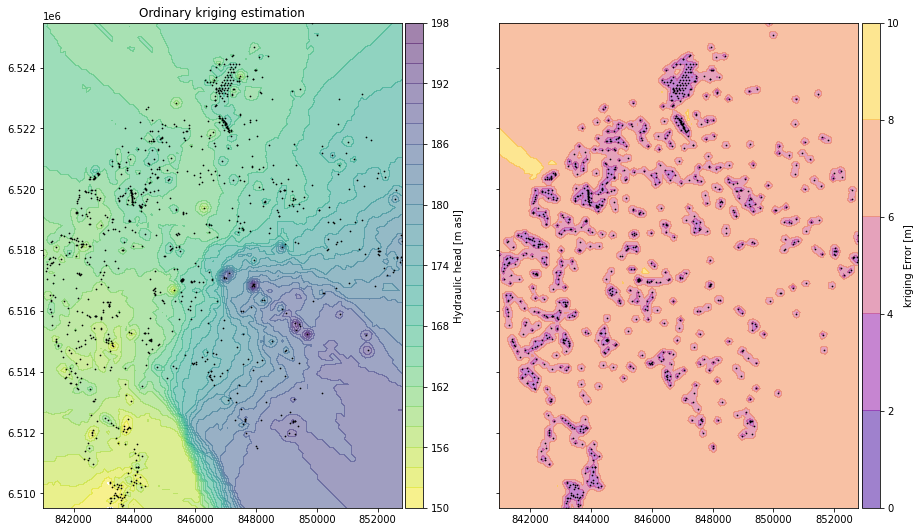

In [63]:
fig, axs = plt.subplots(1, 2 ,figsize=(15, 10), sharey=True)

ax = axs[0]

# Contour fringes of the kriging process:
ctr_hh = ax.contourf(xx, yy, hh_hat,
                     range(150,200,2),
                     cmap = "viridis_r", 
                     alpha = 0.5)

ax.set_title("Ordinary kriging estimation")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_hh, cax=cax, label = 'Hydraulic head [m asl]')

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

ax = axs[1]

# Contour fringes of the kriging error:
ctr_err = ax.contourf(xx, yy, s2,
                      range(0,12,2),
                      cmap = "plasma",
                      alpha = 0.5)

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_err, cax=cax, label = 'kriging Error [m]')

plt.show()

As we can see:
- we are able to make extrapolation with our ordinary kriging model,
- the error increase in areas with a lower density of measurements.

Now, considering that interpolation/extrapolation has no meaning outside the groundwater body of interest, we can make a mask to display the result on relevant locations:

In [64]:
from shapely.geometry import Point

# We initiale a mask with 0 everywhere with the similar shape as earlier
maskin = xx - xx

# In this mask, we assign True if the point is inside the groundwater body
# and we assign False if the point is outside the groundwater body
for i in range(maskin.shape[0]):
    for j in range(maskin.shape[1]):
        xi = xx[i][j]
        yj = yy[i][j]
        if Point(xi, yj).within(area["geometry"][0]):
            maskin[i, j] = 0
        else:
            maskin[i, j] = 1
            
# We apply our mask to previous calculated arrays:
hh_ma = np.ma.masked_array(hh_hat, maskin)
s2_ma = np.ma.masked_array(s2, maskin)

We finally display the result:

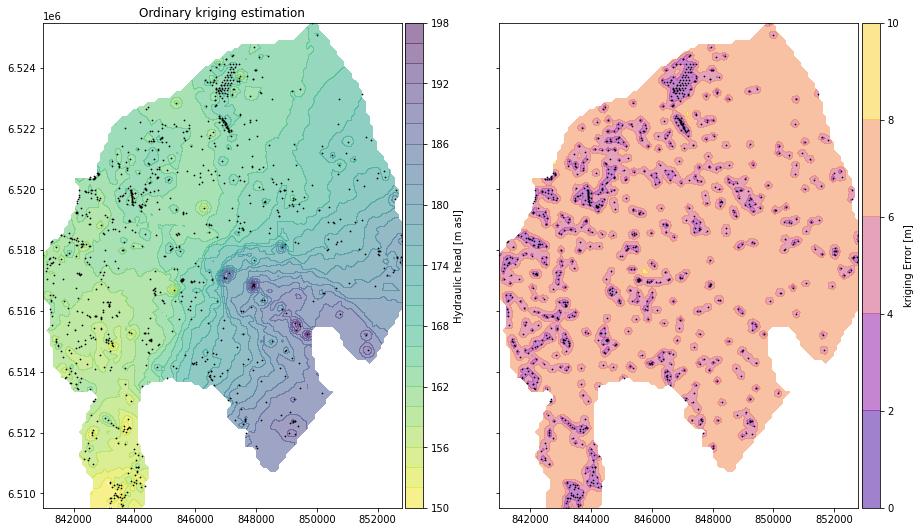

In [65]:
# We plot the results:
fig, axs = plt.subplots(1, 2 ,figsize=(15, 10), sharey=True)

ax = axs[0]
# Contour fringes of the kriging process:
ctr_hh = ax.contourf(xx, yy, hh_ma,
                     range(150,200,2),
                     cmap = "viridis_r", 
                     alpha = 0.5)

ax.set_title("Ordinary kriging estimation")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_hh, cax=cax, label = 'Hydraulic head [m asl]')

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

ax = axs[1]

# Contour fringes of the kriging error:
ctr_err = ax.contourf(xx, yy, s2_ma,
                      range(0,12,2),
                      cmap = "plasma",
                      alpha = 0.5)

# We add the location of points of our dataset
gdf.plot(ax = ax, c = "black", marker= '.', markersize = 2)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ctr_err, cax=cax, label = 'kriging Error [m]')

plt.show()

### Export the result as a shapefile

Now we may want to export our ordinary kriging estimation as a shapefile. So, let's convert resulting array into a geodataframe:

In [ ]:
df_ok = pd.DataFrame({'x': xx.flatten(),
                      'y': yy.flatten(),
                      'hh_k': hh_ma.flatten(),
                      's2': s2_ma.flatten()})

# We remove points without values (in the False part of our mask)
df_ok = df_ok.dropna()

# We transform our df into a geodataframe
export = gpd.GeoDataFrame(df_ok, 
                          geometry=gpd.points_from_xy(df_ok.x, df_ok.y))

export.head()

We can finally save the the shapefile using the `to_file` method:

In [ ]:
export.to_file('my_kriging_export.shp')

### Export the result as a geoTIFF raster

To export the kriging estimation as a geoTIFF please follow the procedure below:

In [22]:
from osgeo import gdal, osr

# we determine the pixel size in x and y directions.
dx = abs(xmax - xmin)/res_x
dy = abs(ymax - ymin)/res_y

# we determine paramaters associated to our iamge
# top left x 
# w-e pixel resolution
# rotation, 0 if image is "north up"
# top left y
# n-s pixel resolution
params =(xmin - dx/2, dx, 0, ymax + dy/2, 0, -dy)

# the name of our geoTIFF
tif_name = "my_kriging_geotiff.tif"
            
# Create/Open the raster
output_raster = gdal.GetDriverByName('GTiff').Create(tif_name, res_x+1, res_y+1, 1 ,gdal.GDT_Float32)

# Specify its coordinates
output_raster.SetGeoTransform(params)

# Establish its coordinate encoding:
srs = osr.SpatialReference() 

# Our projection system is specified:
srs.ImportFromEPSG(2154)                     

# Exports the coordinate system to the file
output_raster.SetProjection(srs.ExportToWkt()) 

# Writes my array to the raster after some transformation due to the resulting shape of the kriging:
output_raster.GetRasterBand(1).WriteArray(np.transpose(np.flip(hh_hat[::-1])))  
output_raster.FlushCache()

# Uncomment below if you want to preview the result:
#import rasterio
#src = rasterio.open(tif_name)
#plt.imshow(src.read(1))

## Few points of discussion

In this notebook, we applied an ordinary kriging method to determine the hydraulic head across an area of interest. The results is in great accordance with the regional understanding of groundwater flow systems. However, our dataset is based on non-synchronous measurements leading to a significative variability which does not allow us to describe draw conclusions regarding local flow systems behavior.

There are many other geostatistical methods derived from the variography study (e.g. simple kriging, ordinary kriging, universal kriging, co-kriging, etc.)

Please note that kriging algorithms can be combine with machine learning and/or deep learning algorithm to improve local estimations: see [Li et al., (2011)](https://doi.org/10.1016/j.envsoft.2011.07.004) and [Li & Heap (2014)](https://doi.org/10.1016/j.envsoft.2013.12.008).